In [89]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
train_df = pd.read_csv('train.csv')

In [91]:
y_train = np.array(train_df['SalePrice'])

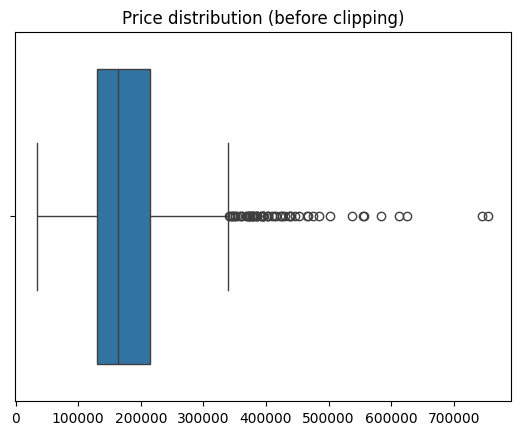

In [92]:
sns.boxplot(x=y_train)
plt.title("Price distribution (before clipping)")
plt.show()

In [93]:
upper_limit = np.percentile(y_train, 99.5)
print(f"99.5th percentile cutoff: ${upper_limit:,.0f}")

99.5th percentile cutoff: $527,332


In [94]:
mask = y_train <= upper_limit
y_train_filtered = y_train[mask]

In [95]:
train_df = train_df.drop(labels=['Id', 'SalePrice'], axis=1)

In [96]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train_df.select_dtypes(include=['object']).columns

In [97]:
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].mean())
train_df[cat_cols] = train_df[cat_cols].fillna("None")

In [98]:
train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)

In [99]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [100]:
scaler = MinMaxScaler()

In [101]:
train_df[train_df.columns] = scaler.fit_transform(train_df)

In [102]:
x_train = np.array(train_df).astype(np.float32)
x_train_filtered = x_train[mask]
y_train = np.array(y_train_filtered).astype(np.float32)
y_train_log = np.log1p(y_train)

In [103]:
from sklearn.model_selection import train_test_split

In [104]:
x_train, x_val, y_train_log, y_val_log = train_test_split(
    x_train_filtered, y_train_log, test_size=0.2, random_state=42)

In [105]:
from keras import regularizers

In [106]:
optimizer = optimizers.RMSprop(learning_rate=0.00005)

In [107]:
def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu", input_shape=(x_train.shape[1],)),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=optimizer,
        loss='mse',             
        metrics=['mae']  
    )
    return model

In [108]:
model = build_model()

/Users/chuck/python-projects/kaggle/ames_housing_prices/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [109]:
tf.config.run_functions_eagerly(True)

In [110]:
tf.keras.backend.clear_session()

In [111]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       133,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,777 (1.39 MB)

 Trainable params: 363,777 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
print(x_train.shape)
print(y_train_log.shape)

(1161, 260)
(1161,)


In [113]:
history = model.fit(x_train, y_train_log, epochs=50, batch_size=128)

Epoch 1/50


/Users/chuck/python-projects/kaggle/ames_housing_prices/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 141.8289 - mae: 11.8996
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 122.1087 - mae: 11.0405
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 101.4612 - mae: 10.0622
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 78.9221 - mae: 8.8710
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 56.4490 - mae: 7.4945
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 34.6998 - mae: 5.8641
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 17.1387 - mae: 4.0930
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 5.5878 - mae: 2.2818
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.0508 - mae: 0.8790
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.3263 - mae: 0.4457
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.2749 - mae: 0.4100
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.2427 - mae: 0.3882
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━

In [114]:
val_preds_log = model.predict(x_val)
val_preds = np.expm1(val_preds_log)
y_val = np.expm1(y_val_log)
mae = np.mean(np.abs(val_preds - y_val))
print(f"Validation MAE on original scale: ${mae:,.0f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Validation MAE on original scale: $80,355


In [115]:
val_loss = model.evaluate(x_val, y_val_log, verbose=0)
print("Validation loss", val_loss)

Validation loss [0.18630735576152802, 0.37446853518486023]


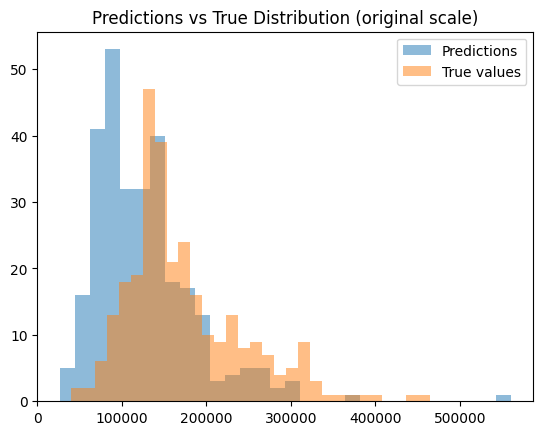

In [116]:
plt.hist(val_preds, bins=30, alpha=0.5, label="Predictions")
plt.hist(y_val, bins=30, alpha=0.5, label="True values")
plt.legend()
plt.title("Predictions vs True Distribution (original scale)")
plt.show()

In [117]:
val_preds_log = model.predict(x_val)
val_preds = np.expm1(val_preds_log.flatten())
y_val = np.expm1(y_val_log.flatten())

rmse = np.sqrt(np.mean((val_preds - y_val)**2))
print(f"Validation RMSE: ${rmse:,.0f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Validation RMSE: $62,224
